# Introduction
This tutorial introduces the concept of causality for time series and demonstrates ways of checking for causal links between different time series in Python.

## Motivation

In fields where certain metrics need to be boosted (such as driving more page views to a website or increasing the engagement of users with an app), it is helpful to know the root causes for changes in the metrics being measured i.e. which fundamental quantities are affecting these important metrics. When all the metrics are being monitored, we have a dataset of time series on which certain statistical analysis can be done to obtain the probable causes of the key performance indicators (**KPIs**). 

This kind of analysis is considered a stronger measure of relatedness than simple correlation tests. Analysts can use inferences of causality as **"actionable insights"** in a business intelligence setting.

For example, take a group of analysts monitoring various metrics (time-series) from an e-commerce website. If they are able to identify the causes of increase in **purchases** of a particular product (where the cause might be **clicks on ads** on a certain search result page), they can instruct the marketers of the product to further boost those causes (to buy more ads on similar search result pages to further increase clicks on ads from such pages, in this case).

### Tutorial content

We will cover the following topics in this tutorial:
* [Installing the libraries](#Installing-the-libraries)
* [Generating Synthetic Data](#Generating-Synthetic-Data)
* [Time Series Concepts](#Time-Series-Concepts)
  * [Lags](#Lags)
  * [Stationarity](#Stationarity)
  * [Autocorrelation](#Autocorrelation)
  * [Cross-correlation](#Cross-correlation)
* [Causality](#Causality)
* [Granger Causality](#Granger-Causality)

## Installing the libraries
Install statsmodels using anaconda GUI **OR** Run the following command:

    $ conda install statsmodels
    
All other libraries should already be installed as part of previous assignments. If not, you can install them using conda on terminal or anaconda GUI.

In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statsmodels.tsa.stattools as stattools
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Generating Synthetic Data
We'll be synthesizing data for the purpose of demonstrating various library functions.
We take two simple sinusoids with different amplitudes, phases and periods (and some noise). These are the causes in our example.
We create the "effect" time series by taking a linear combination of these two causes and adding a small noise.

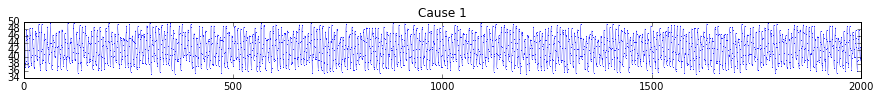

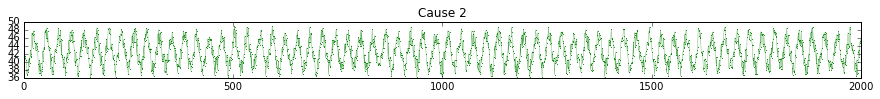

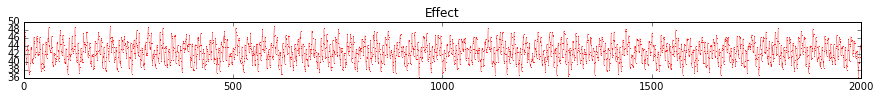

In [2]:
# total number of data points
numX = 2010

# maximum lag number allowed to be a cause
maxLag = 10
def genTS(numX = 2000, noiseSize = 10, amplitude = 10, shift = 0, period = 0.3,height=30):
    x = np.linspace(1,numX,num=numX)
    noise = noiseSize*np.random.rand(numX)
    xSeries = pd.Series(x)
    periodic = xSeries.apply(lambda x: height+amplitude*math.sin((2*math.pi/period)*(x+shift)))
    TS = periodic + noise
    return TS,xSeries
#seeding random number generator
random.seed(0)
# generating random time series to be used as Causes
Cause1,xSeries = genTS(numX=numX,noiseSize = 5, amplitude = 5, shift = 6, period = 7,height=40)
random.seed(1)
Cause2,_ = genTS(numX=numX,noiseSize = 5, amplitude = 4, shift = 4, period = 30,height=40)

# Creating dependent variable time series (Effect) by combining Causes and some noise
noiseSize = 0.1
effectNoise = pd.Series(noiseSize*np.random.rand(numX))
Effect = pd.Series(0.5*Cause1.shift(3)+0.5*Cause2.shift(5)+effectNoise)

# Truncating all series to valid range by re-initializing the pandas Series
Cause1 = pd.Series(Cause1[maxLag:].tolist())
Cause2 = pd.Series(Cause2[maxLag:].tolist())
Effect = pd.Series(Effect[maxLag:].tolist())
xSeries = pd.Series(np.linspace(1,numX-maxLag,num=numX-maxLag))
# plotting causes and effect
plt.figure(figsize=(15,1))
plt.plot(xSeries,Cause1,marker='.',color='blue',markersize=1, linewidth=0.25)
plt.title('Cause 1')
plt.show()
plt.figure(figsize=(15,1))
plt.plot(xSeries,Cause2,marker='.',color='green',markersize=1, linewidth=0.25)
plt.title('Cause 2')
plt.show()
plt.figure(figsize=(15,1))
plt.plot(xSeries,Effect,marker='.',color='red',markersize=1, linewidth=0.25)
plt.title('Effect')
plt.show()

## Time Series Concepts

### Lags
To talk about pairs of time series being cause and effect, we must first define the notion of a lag of a time series.

The $n^{th}$ lag of a time series can be informally defined as the series shifted $n$ datapoints to the right. This delayed series is used to model the value of one time series using the values of various time series at earlier time points.

The lag of a pandas Series can be computed using the `shift` function.

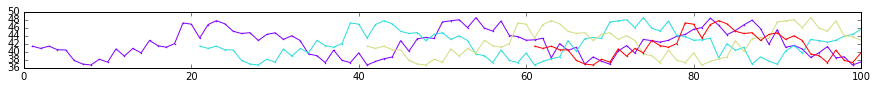

In [3]:
numY = 4
colors = cm.rainbow(np.linspace(0, 1, numY))
# plotting lags of the second cause in multiples of 20
plt.figure(figsize=(15,1))
for i, c in zip(range(numY), colors):
    plt.plot(xSeries[:100],Cause2.shift(20*i)[:100],marker='.',color=c,markersize=2, linewidth=1)
plt.show()

The above plot shows the first 100 datapoints for the time series for Cause 2 and its' lags in multiple of 20. These lagged time series are shorter as the shifting requires us to drop some data.

### Stationarity
A time series is said to be stationary if various statistics about it remain constant over its entire range. We need this to hold for time series before we can apply the granger causality test.

To establish stationarity, we can inspect the graph of the time series. To be more rigourous, we can apply a statistical test called the Adfuller Test whose null hypothesis is that there exists a unit root for the time series. 

The existence of a unit root (non-zero linear trend) implies non-stationarity. Thus, the null hypothesis must be rejected. To be reasonably sure (95%) about our test result, we compare our sample's p-value with 0.05 and decide accordingly.


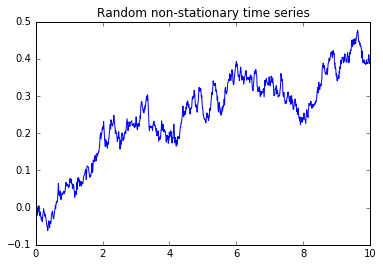

randomNonStat is False


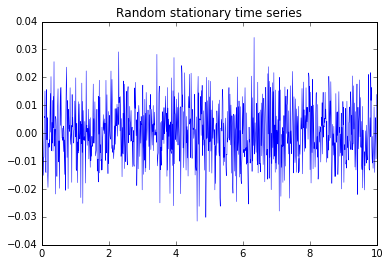

For randomStat, stationarity test is True
For Cause 1, stationarity test is True
For Cause 2, stationarity test is True
For Effect, stationarity test is True


In [4]:
def is_stationary(TS):
    testResults = stattools.adfuller(TS)
    return testResults[1]<0.05

# Generating random non-stationary time series
np.random.seed(1)
x = np.linspace(0,10,1000)
randomNonStat = np.cumsum(0.01*np.random.randn(1000))
# Generating random stationary time series
randomStat = 0.01*np.random.randn(1000)
plt.plot(x,randomNonStat,'-')
plt.title('Random non-stationary time series')
plt.show()
print 'randomNonStat is',is_stationary(randomNonStat)
plt.plot(x,randomStat,markersize=2, linewidth=0.5)
plt.title('Random stationary time series')
plt.show()
print 'For randomStat, stationarity test is',is_stationary(randomStat)
print 'For Cause 1, stationarity test is',is_stationary(Cause1)
print 'For Cause 2, stationarity test is',is_stationary(Cause2)
print 'For Effect, stationarity test is',is_stationary(Effect)

### Autocorrelation
[Autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation), also known as serial correlation, is the correlation of a signal with itself at different points in time. We can use this to determine whether the given time series has some periodicity. The definition of autocorrelation with the $\tau_{th}$ lag is:
$$R(\tau) = \frac{\operatorname{E}[(X_t - \mu)(X_{t+\tau} - \mu)]}{\sigma^2}$$
There is a pre-defined function `"autocorr"` in `pandas` for this purpose.

We can write a function to plot the autocorrelations of a time series with some or all of its lags.
For a sinusoid the autocorrelation is maximised at multiples of the period as well as for really small lags.

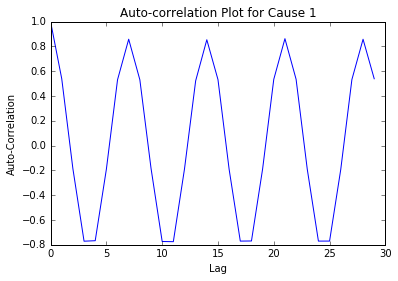

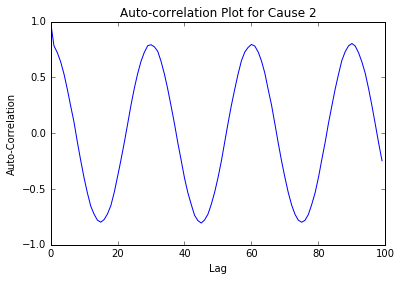

/Users/dhruv/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


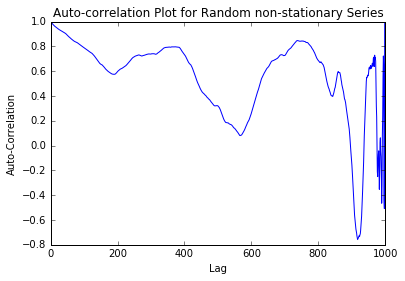

In [5]:
def plotAutoCorrs(TS,TSname,xSize=-1):
    TS=pd.Series(TS)
    if xSize == -1:
        xSize = len(TS)
    acs = [TS.autocorr(lag=i) for i in range(xSize)]
    plt.plot(range(len(acs)), acs,'-',markersize=1)
    plt.ylabel("Auto-Correlation")
    plt.xlabel("Lag")
    plt.title("Auto-correlation Plot for "+TSname)
    plt.show()
plotAutoCorrs(Cause1,"Cause 1",30)
plotAutoCorrs(Cause2,"Cause 2",100)
plotAutoCorrs(randomNonStat,"Random non-stationary Series")

As we can see from this plot, the auto-correlation of the time series spikes for lags that are multiples of its period. If the time series is not periodic, the plot doesn't have any significant and regular peaks after lag 0.

### Cross-correlation
[Cross-correlation](#https://en.wikipedia.org/wiki/Cross-correlation) is a measure of similarity of two series as a function of the lag of one relative to the other. The definition of cross-correlation of $f$ with the $\tau_{th}$ lag of $g$ is:
$$(f \star g)(\tau)\ \stackrel{\mathrm{def}}{=} \int_{-\infty}^{\infty} f^*(t)\ g(t+\tau)\,dt$$

There is no pre-defined function for this, but a wrapper can easily be made using the `corr` function in pandas:

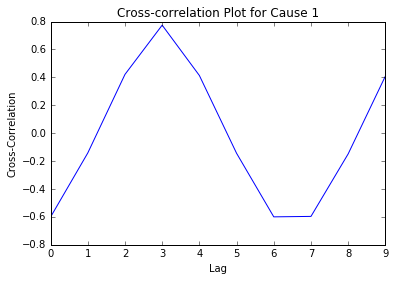

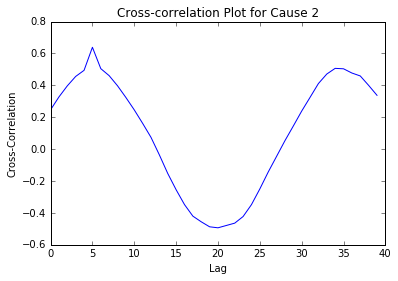

In [6]:
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))
def plotCrossCorrs(TS,TS2,xSize=-1,TSname=""):
    TS=pd.Series(TS)
    if xSize == -1:
        xSize = len(TS)
    acs = [crosscorr(TS,TS2,i) for i in range(xSize)]
    plt.plot(range(len(acs)), acs,'-',markersize=1)
    plt.ylabel("Cross-Correlation")
    plt.xlabel("Lag")
    plt.title("Cross-correlation Plot for "+TSname)
    plt.show()
plotCrossCorrs(Effect,Cause1,10,'Cause 1')
plotCrossCorrs(Effect,Cause2,40,'Cause 2')

This plot shows that the effect is cross-correlated with the causes. However the extent of correlation with each individual cause is less than with itself (as the peaks reach only around 0.8 and 0.6 here). The peaks match the lag from which the Effect was generated.

### Causality

Real world processes are often modeled with cause and effect relationships in the following way:
<img src='causegraph.png'>
In principle, such causality can be established by conducting a controlled experiment where all factors are kept constant across two setups except the probably cause we are testing. If the changes in the observations are significant, we can say with high certainty that the factor that is varied. As it is not always possible to manipulate the probable causes for experimentation, we must use statistical causality as an alternative to check the causal connnection.

### Granger Causality

As the true model through which data is being generated is not known in real world problems, we must settle for a weaker notion of causality that is defined under certain statistical conditions. 

Take $Y$ as the time series for which causes must be found.

The hypothesis that is checked for [Granger Causality](https://en.wikipedia.org/wiki/Granger_causality) is:
$${P}[Y(t+1) \in A\mid \mathcal{I}(t)] \neq \mathbb{P}[Y(t+1) \in A\mid \mathcal{I}_{-X}(t)]$$



In simple terms this formula says: 

"If the lags of a set of time series $Y,X_1,X_2,..$ can model $Y$ better than lags of $Y$ alone, then the $X_i$s are the 'granger-causes' of $Y$."

We can use the `statmodels` library in python which performs this test for us.

Since the routine just gives us p-values for multiple statistical tests, it is difficult produce an absolute answer from the results, but they can be qualitatively assessed to make a judgement on whether the causal link exists or not.

In [7]:
random.seed(0)
# Forming input for the library function
twoDarray = np.vstack((np.array(Effect.tolist()),np.array(Cause1.tolist()))).T
results = stattools.grangercausalitytests(twoDarray,maxLag,verbose=False)
# printing results
for i in [1,2,3]:
    for k in results[i][0]:
        print i,k,'p-value:',results[1][0][k][1]

        

1 lrtest p-value: 1.91327099381e-74
1 params_ftest p-value: 2.56206045133e-74
1 ssr_ftest p-value: 2.56206045116e-74
1 ssr_chi2test p-value: 7.64297120705e-81
2 lrtest p-value: 1.91327099381e-74
2 params_ftest p-value: 2.56206045133e-74
2 ssr_ftest p-value: 2.56206045116e-74
2 ssr_chi2test p-value: 7.64297120705e-81
3 lrtest p-value: 1.91327099381e-74
3 params_ftest p-value: 2.56206045133e-74
3 ssr_ftest p-value: 2.56206045116e-74
3 ssr_chi2test p-value: 7.64297120705e-81


Since the p-values are very low, the null hypothesis of the library function (non-granger-causality) cannot be rejected. This means `Cause1` alone is not a granger cause of `Effect`.
**However, the library provides no way of testing if multiple causes better approximate $Y$.**

Hence, we must fit linear models for both cases and manually see if the one with probable causes fits better.

First, we find how well the lags of the Effect can model it.

In [8]:
# Creating Data Frame
d = {'Cause1': Cause1, 'Cause2': Cause2, 'Effect':Effect}
df = pd.DataFrame(data=d)
dict1 = {}
dict2 = {}

# Creating formula for hypothesis function
# and DataFrame of lags needed. Causei_j is the j'th lag of the i'th cause
formulaString = 'Effect ~ '
for i in range(1,maxLag):
    formulaString +='Effect_'+str(i)+' + '
    dict1['Effect_'+str(i)] = df['Effect'].shift(i)
df1 = pd.DataFrame(dict1)
df2 = pd.DataFrame(dict2)
df = pd.concat((df,df1,df2),axis = 1)
print 'The hypothesis function being fitted: '
print formulaString[:-2]

# using ordinary least squares to fit our function and find coefficients
mod = ols(formula=formulaString[:-2], data=df)
res = mod.fit()
print res.summary()


The hypothesis function being fitted: 
Effect ~ Effect_1 + Effect_2 + Effect_3 + Effect_4 + Effect_5 + Effect_6 + Effect_7 + Effect_8 + Effect_9 
                            OLS Regression Results                            
Dep. Variable:                 Effect   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     568.1
Date:                Thu, 03 Nov 2016   Prob (F-statistic):               0.00
Time:                        21:09:33   Log-Likelihood:                -3368.6
No. Observations:                1991   AIC:                             6757.
Df Residuals:                    1981   BIC:                             6813.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.

Notice the coefficient column above. There is no single lag that is a good predictor of the Effect.

Next, we **include the lags of the probable causes** and fit the linear function again.

In [9]:
# Creating Data Frame
d = {'Cause1': Cause1, 'Cause2': Cause2, 'Effect':Effect}
df = pd.DataFrame(data=d)
dict1 = {}
dict2 = {}

# Creating formula for hypothesis function
# and DataFrame of lags needed. Causei_j is the j'th lag of the i'th cause
formulaString = 'Effect ~ '
for i in range(1,maxLag):
    formulaString +='Effect_'+str(i)+' + '
    dict1['Effect_'+str(i)] = df['Effect'].shift(i)
    formulaString +='Cause1_'+str(i)+' + '
    dict1['Cause1_'+str(i)] = df['Cause1'].shift(i)
    formulaString +='Cause2_'+str(i)+' + '
    dict2['Cause2_'+str(i)] = df['Cause2'].shift(i)
df1 = pd.DataFrame(dict1)
df2 = pd.DataFrame(dict2)
df = pd.concat((df,df1,df2),axis = 1)
print 'The hypothesis function being fitted: '
print formulaString[:-2]
mod = ols(formula=formulaString[:-2], data=df)
res = mod.fit()
print res.summary()


The hypothesis function being fitted: 
Effect ~ Effect_1 + Cause1_1 + Cause2_1 + Effect_2 + Cause1_2 + Cause2_2 + Effect_3 + Cause1_3 + Cause2_3 + Effect_4 + Cause1_4 + Cause2_4 + Effect_5 + Cause1_5 + Cause2_5 + Effect_6 + Cause1_6 + Cause2_6 + Effect_7 + Cause1_7 + Cause2_7 + Effect_8 + Cause1_8 + Cause2_8 + Effect_9 + Cause1_9 + Cause2_9 
                            OLS Regression Results                            
Dep. Variable:                 Effect   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.542e+05
Date:                Thu, 03 Nov 2016   Prob (F-statistic):               0.00
Time:                        21:09:33   Log-Likelihood:                 4260.2
No. Observations:                1991   AIC:                            -8464.
Df Residuals:                    1963   BIC:                            -8308.
Df Model:               

In this case, the model learnt reflects the actual causes (`Cause1_3` and `Cause2_5`) from which the `Effect` was generated.

From the log likelihood values of both models (highly negative value v/s highly positive value), it is clear that the model with probable causes fits the function much better.

This means that `Cause1` and `Cause2` are Granger causes of the `Effect` time series.

For more rigor and uniformity, statistical tests can be applied to these results, but in this case, we are sure of the conclusion.

## Summary and references

This tutorial has outlined the procedure to check for statistical causality between time series. It is important to remember that the inferences obtained from the above are not absolute truths but statistically probable statements.

For real datasets, it might not be possible to establish causality even if one of the independent time series is known to be a definite cause as some of the causes might not be captured by our dataset. This will result in $Y$'s lags modelling it better than the potential causes.

1. General Time Series questions: http://stats.stackexchange.com/?tags=time-series
2. Granger Causality concept: http://www.scholarpedia.org/article/Granger_causality
3. Statistical tests for Granger Causality: http://davegiles.blogspot.com/2011/04/testing-for-granger-causality.html (further reading)
3. Statsmodels library: 
    1. Adfuller Test: http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html
    2. Granger Causality Test: http://statsmodels.sourceforge.net/0.6.0/generated/statsmodels.tsa.stattools.grangercausalitytests.html